In [1]:
import sys
base_path = 'C:\\github\\aide-analysis'
sys.path.append(base_path)

from core.config import Config
config = Config()
config.RAWDATA_PATH

# 사전처리
from src.temp import *
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
import glob
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings(action='ignore')

# DataFrame 디스플레이 설정
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
pd.set_option('display.width', 100)

# Pandas Float 자릿수 표시 제한
pd.options.display.float_format = '{:.2f}'.format

# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

In [2]:
# 빅쿼리 연결
from src.bigquery import bigquery_client, bigquery
bq = bigquery_client

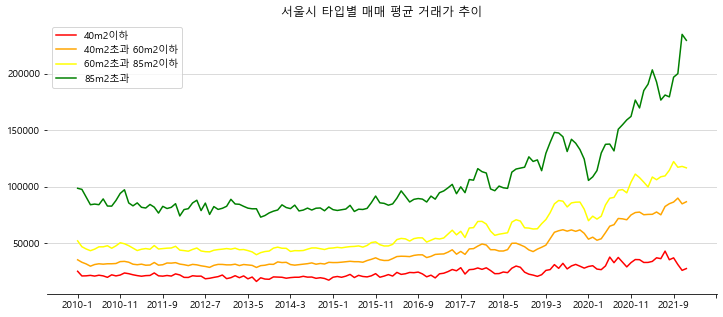

In [3]:


sql = f"""
SELECT T1.contractYear,
       T1.contractMonth, 
       T1.pyeong, 
       AVG(T1.transactionPrice)
FROM(
        SELECT contractYear,
               contractMonth,
               transactionPrice,
               CASE 
               WHEN jeonyongArea <= 40 THEN '40m2이하'
               WHEN jeonyongArea > 40 AND jeonyongArea <=60 THEN '40m2초과 60m2이하'
               WHEN jeonyongArea >60 AND jeonyongArea <=85 THEN '60m2초과 85m2이하'
               ELSE '85m2초과' 
               END AS pyeong
        FROM `aidepartners.aide.transaction_price_apartment_trading`
        WHERE contractYear >=2010 and 
              contractYear <=2021 and
              pnuCode LIKE '11%'
    ) AS T1 
GROUP BY T1.contractYear, T1.contractMonth, pyeong
ORDER BY T1.contractYear, T1.contractMonth, pyeong;
"""
df = bq.query(sql).to_dataframe()

df[['contractYear','contractMonth']] = df[['contractYear','contractMonth']].astype('str')
df['date']= df['contractYear'] + '-' + df['contractMonth']

df1 = df[df['pyeong']=='40m2이하']
df2 = df[df['pyeong']=='40m2초과 60m2이하']
df3 = df[df['pyeong']=='60m2초과 85m2이하']
df4 = df[df['pyeong']=='85m2초과']
fig, ax = plt.subplots(figsize = (12, 5))
ax.plot(df1['date'], df1['f0_'],c = 'red',label = '40m2이하')
ax.plot(df2['date'], df2['f0_'],c = 'orange',label = '40m2초과 60m2이하')
ax.plot(df3['date'], df3['f0_'],c = 'yellow',label = '60m2초과 85m2이하')
ax.plot(df4['date'], df4['f0_'],c = 'green',label = '85m2초과')

# xticks개수 조절
ax.xaxis.set_major_locator(MaxNLocator(16)) 

# 그리드 추가
ax.grid(axis="y", c="lightgray") # "axis = 'x'" 는 x축 세로선 grid생성

# 필요없는 선 제거
ax.spines[["left", "top", "right"]].set_visible(False)



plt.title('서울시 타입별 매매 평균 거래가 추이')
plt.legend()

위에 있는 시각화 자료를 통해서는 인사이트를 얻기 힘들어 보인다. 다른 시각화 방법을 사용해보자

In [6]:
# 매매가를 통화가치가 아닌 지수화 
df1['f0_'] = df1['f0_'].apply(lambda x: (x/df1['f0_'].iloc[0])-1 )
df2['f0_'] = df2['f0_'].apply(lambda x: (x/df2['f0_'].iloc[0])-1 )
df3['f0_'] = df3['f0_'].apply(lambda x: (x/df3['f0_'].iloc[0])-1 )
df4['f0_'] = df4['f0_'].apply(lambda x: (x/df4['f0_'].iloc[0])-1 )

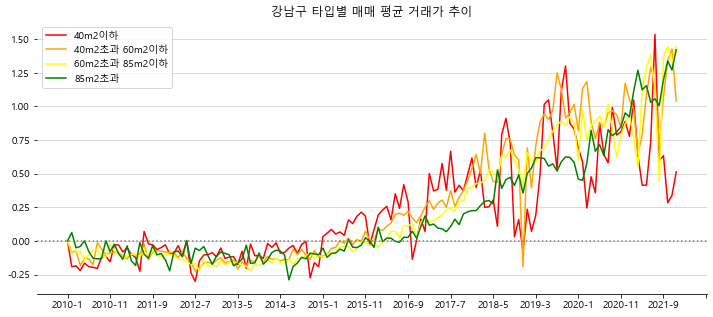

In [7]:
fig, ax = plt.subplots(figsize = (12, 5))
ax.plot(df1['date'], df1['f0_'],c = 'red',label = '40m2이하')
ax.plot(df2['date'], df2['f0_'],c = 'orange',label = '40m2초과 60m2이하')
ax.plot(df3['date'], df3['f0_'],c = 'yellow',label = '60m2초과 85m2이하')
ax.plot(df4['date'], df4['f0_'],c = 'green',label = '85m2초과')

# xticks개수 조절
ax.xaxis.set_major_locator(MaxNLocator(16)) 

# 그리드 추가
ax.grid(axis="y", c="lightgray") # "axis = 'x'" 는 x축 세로선 grid생성

# 필요없는 선 제거
ax.spines[["left", "top", "right"]].set_visible(False)

# 0점선
ax.axhline(y=0, c="gray", ls=":") 

plt.title('강남구 타입별 매매 평균 거래가 추이')
plt.legend()

In [ ]:
# 평단가


# 전월대비(기준시점 x, 해당 월 대비 전월 기준 증감)

